(mmm_time_slice_cross_validation)=
# Time-Slice-Cross-Validation and Parameter Stability

Perform time-slice cross validation for a media mix model. This is an important step to evaluate the stability and quality of the model. We not only look into out of sample predictions but also the stability of the model parameters.

## Prepare Notebook

In [0]:
import warnings
from dataclasses import dataclass

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns
import logging
import numpyro
import pprint
from itertools import combinations
import matplotlib.dates as mdates
import ray
import time
import mlflow

from pymc_marketing.metrics import crps
from pymc_marketing.mmm import (
    MMM,
    GeometricAdstock,
    LogisticSaturation,
)
from pymc_marketing.mmm.utils import apply_sklearn_transformer_across_dim
from pymc_marketing.prior import Prior

warnings.simplefilter(action="ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"
# dropdown widget
dbutils.widgets.dropdown("quality_type", "QDAU", ["QDAU", "DAU"])
dbutils.widgets.dropdown("audience", "new_winback", ["new_winback", "returning"])

# databricks job parameters
dbutils.widgets.dropdown("intercept_prior", "dist=TruncatedNormal_mu=0.5_sigma=0.05_lower=0.4_upper=0.7", ["dist=TruncatedNormal_mu=0.5_sigma=0.05_lower=0.4_upper=0.7", "dist=TruncatedNormal_mu=0.2_sigma=0.1_lower=0.1","dist=TruncatedNormal_mu=0.3_sigma=0.1_lower=0.1", "dist=TruncatedNormal_mu=0.4_sigma=0.1_lower=0.1", "dist=TruncatedNormal_mu=0.5_sigma=0.1_lower=0.1", "dist=HalfNormal_sigma=1"])
dbutils.widgets.dropdown("adstock_alpha_prior", 'uniform', ['spend_imps_ratio', 'contrib_imps_ratio', 'uniform'])
dbutils.widgets.dropdown("gamma_control_prior", "dist=Normal_mu=0_sigma=.05_dims=control", ["dist=Normal_mu=0_sigma=.025_dims=control", "dist=Normal_mu=0_sigma=.03_dims=control", "dist=Normal_mu=0_sigma=.05_dims=control", "dist=Normal_mu=0_sigma=.1_dims=control"])
dbutils.widgets.dropdown("saturation_beta_prior_sigma", "prior_imps_share_sigma", ["prior_imps_share_sigma", "prior_spend_share_sigma", "prior_contribution_share_sigma"])

dbutils.widgets.text("sample_tuneups", "750")
tuneups = int(dbutils.widgets.get("sample_tuneups"))

dbutils.widgets.text("sample_draws", "750")
draws = int(dbutils.widgets.get("sample_draws"))

dbutils.widgets.dropdown("trend_type", "annual", ["month", "annual"])
trend_type = (dbutils.widgets.get("trend_type"))

intercept_prior = dbutils.widgets.get("intercept_prior")
adstock_alpha_prior = dbutils.widgets.get("adstock_alpha_prior")
gamma_control_prior = dbutils.widgets.get("gamma_control_prior")
saturation_beta_prior_sigma = dbutils.widgets.get("saturation_beta_prior_sigma")
audience = dbutils.widgets.get("audience")
quality_type = dbutils.widgets.get("quality_type")

if mlflow.active_run():
    mlflow.end_run()



Initiate mlflow logging

In [0]:

mlflow.start_run()
mlflow.log_param("quality_type", quality_type)
mlflow.log_param("audience", audience)
mlflow.log_param("intercept_prior", intercept_prior)
mlflow.log_param("adstock_alpha_prior", adstock_alpha_prior)
mlflow.log_param("gamma_control_prior", gamma_control_prior)
mlflow.log_param("saturation_beta_prior_sigma", saturation_beta_prior_sigma)
mlflow.log_param("trend_type", trend_type)
mlflow.log_param("sample_tuneups", tuneups)
mlflow.log_param("sample_draws", draws)


run = mlflow.active_run()
if run:
    print("Active run name:", run.info.run_name)
else:
    print("⚠️ No active MLflow run.")

# Add a description of the experiment
description = "Even more restrictive gamma control (sd=.03)"
mlflow.set_tag("mlflow.note.content", description)

Active run name: unique-kit-809


From the widgets or job parameters, we can customize the hyperpriors space:

In [0]:
def parse_prior_config_string(config_str: str) -> Prior:
    """
    Parse a string like 'dist=Normal_mu=0.5_sigma=0.1' into a Prior object.
    Supports flat (non-nested) prior definitions.
    """
    if not config_str:
        return ""

    parts = config_str.strip().split("_")
    config = {}

    for part in parts:
        if "=" not in part:
            raise ValueError(f"Invalid part '{part}': expected key=value format")
        key, value = part.split("=", 1)
        config[key] = value

    if "dist" not in config:
        raise ValueError("Missing 'dist' key in prior definition.")

    dist_name = config.pop("dist")
    # Convert numeric strings to float
    kwargs = {
        k: float(v) if v.replace(".", "", 1).isdigit() or "e" in v.lower() else v
        for k, v in config.items()
    }

    return Prior(dist_name, **kwargs)


model_config_param = {
    "intercept": parse_prior_config_string(intercept_prior),
    "gamma_control": parse_prior_config_string(gamma_control_prior),
}

In [0]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Read Data

Read data of daily active users

In [0]:
# Import daily active users
dau_df = spark.sql("SELECT * FROM datascience.shua.mmm_dau").toPandas()

# Lowercase all column names
dau_df.columns = [col.lower() for col in dau_df.columns]

# Replace 'winback' with 'new' in the start_type column
dau_df["start_type"] = dau_df["start_type"].replace("WINBACK", "NEW")

# Group by date, start_type, and quality_flag, summing daily_users
dau_df = (
    dau_df.groupby(["status_date", "start_type"], as_index=False)["daily_users"]
    .sum()
    .rename(columns={"status_date": "day_dt"})
)

# pivot by start_type
dau_df = pd.pivot_table(dau_df, index="day_dt", columns="start_type", values="daily_users").reset_index()

# rename columns
dau_df.columns = ["day_dt", "y_new_winback_dau", "y_returning_dau"]

dau_df.columns = [col.lower() for col in dau_df.columns]
dau_df['day_dt'] = pd.to_datetime(dau_df["day_dt"])


Read mmm data

In [0]:
raw_df = spark.sql("select * from datascience.shua.mmm_data_wide_042425").toPandas()
raw_df["day_dt"] = pd.to_datetime(raw_df["day_dt"], errors="coerce")
# join with dau_df
raw_df = pd.merge(
    raw_df,
    dau_df,
    on="day_dt",
    how="left",
)
# rename a column
raw_df = raw_df.rename(columns={"y_new_winback": "y_new_winback_qdau", "y_returning": "y_returning_qdau"})


Define important events/anomalies

In [0]:

# Map the event dictionary of notable events
# look for holidays that start on weekends and could have a holiday effect on the following Monday
events_dict = {
    "2023-01-01": "ny23_2023",
    "2023-01-16": "mlk_2023",
    "2023-02-12": "superbowl_2023",
    "2023-02-13": "day_after_superbowl_2023",
    "2023-02-20": "pres_2023",
    "2023-03-24": "anomaly_3_24_23",  # roku stitcher bug start
    "2023-03-25": "anomaly_3_25_23",
    "2023-03-26": "anomaly_3_26_23",
    "2023-03-27": "anomaly_3_27_23",
    "2023-03-28": "anomaly_3_28_23",  # roku stitcher bug end
    "2023-05-29": "mem_2023",
    "2023-06-19": "juneteenth_2023",
    "2023-07-04": "ind_2023",
    "2023-09-04": "lab_2023",
    "2023-11-23": "thanks_2023",
    "2023-11-24": "blk_fri_2023",
    "2023-12-17": "anomaly_12_17_23",  # bug
    "2023-12-20": "anomaly_12_20_2023",  # bug
    "2023-12-21": "anomaly_12_21_2023",  # bug
    "2023-12-23": "day_b4_xmas_eve_2023",
    "2023-12-24": "xmas_eve_2023",
    "2023-12-25": "xmas_2023",
    "2023-12-26": "xmas_day_after_2023",
    "2023-12-30": "day_b4_nye_2023",
    "2023-12-31": "nye_2023",
    "2024-01-01": "ny24_2024",
    "2024-01-15": "mlk_2024",
    "2024-02-11": "anomaly_2_11_2024",  # bug
    "2024-02-19": "pres_2024",
    "2024-03-12": "anomaly_3_11_2024",  # bug
    "2024-03-12": "anomaly_3_12_2024",  # bug
    "2024-03-13": "anomaly_3_13_2024",  # bug
    "2024-03-14": "anomaly_3_14_2024",  # bug
    "2024-03-15": "anomaly_3_15_2024",  # bug
    "2024-05-27": "mem_2024",
    "2024-06-19": "juneteenth_2024",
    "2024-07-04": "ind_2024",
    "2024-09-02": "lab_2024",
    "2024-11-28": "thanks_2024",
    "2024-11-29": "blk_fri_2024",
    "2024-12-24": "xmas_eve_2024",
    "2024-12-25": "xmas_2024",
    "2024-12-31": "nye_2024",
    "2024-02-11": "superbowl_2024",
    "2024-02-12": "day_after_superbowl_2024",
}



# Map the event names to the 'event' column
raw_df['event'] = pd.to_datetime(raw_df['day_dt'], errors='coerce').dt.strftime('%Y-%m-%d').map(events_dict)

# One-hot encode events
event_dummies = pd.get_dummies(raw_df["event"], prefix="event_", prefix_sep="")
event_dummies = (event_dummies >= 1).astype(int)
daily_df = pd.concat([raw_df, event_dummies], axis=1).sort_values("day_dt").reset_index(drop=True)


# One-hot encode day of week
dow_dummies = pd.get_dummies(daily_df["day_dt"].dt.dayofweek, prefix="dow_", prefix_sep="")
dow_dummies = (dow_dummies >= 1).astype(int)
daily_df = pd.concat([daily_df, dow_dummies], axis=1)

Plot of y_vars

/root/.ipykernel/6336/command-2764664206341480-510062332:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


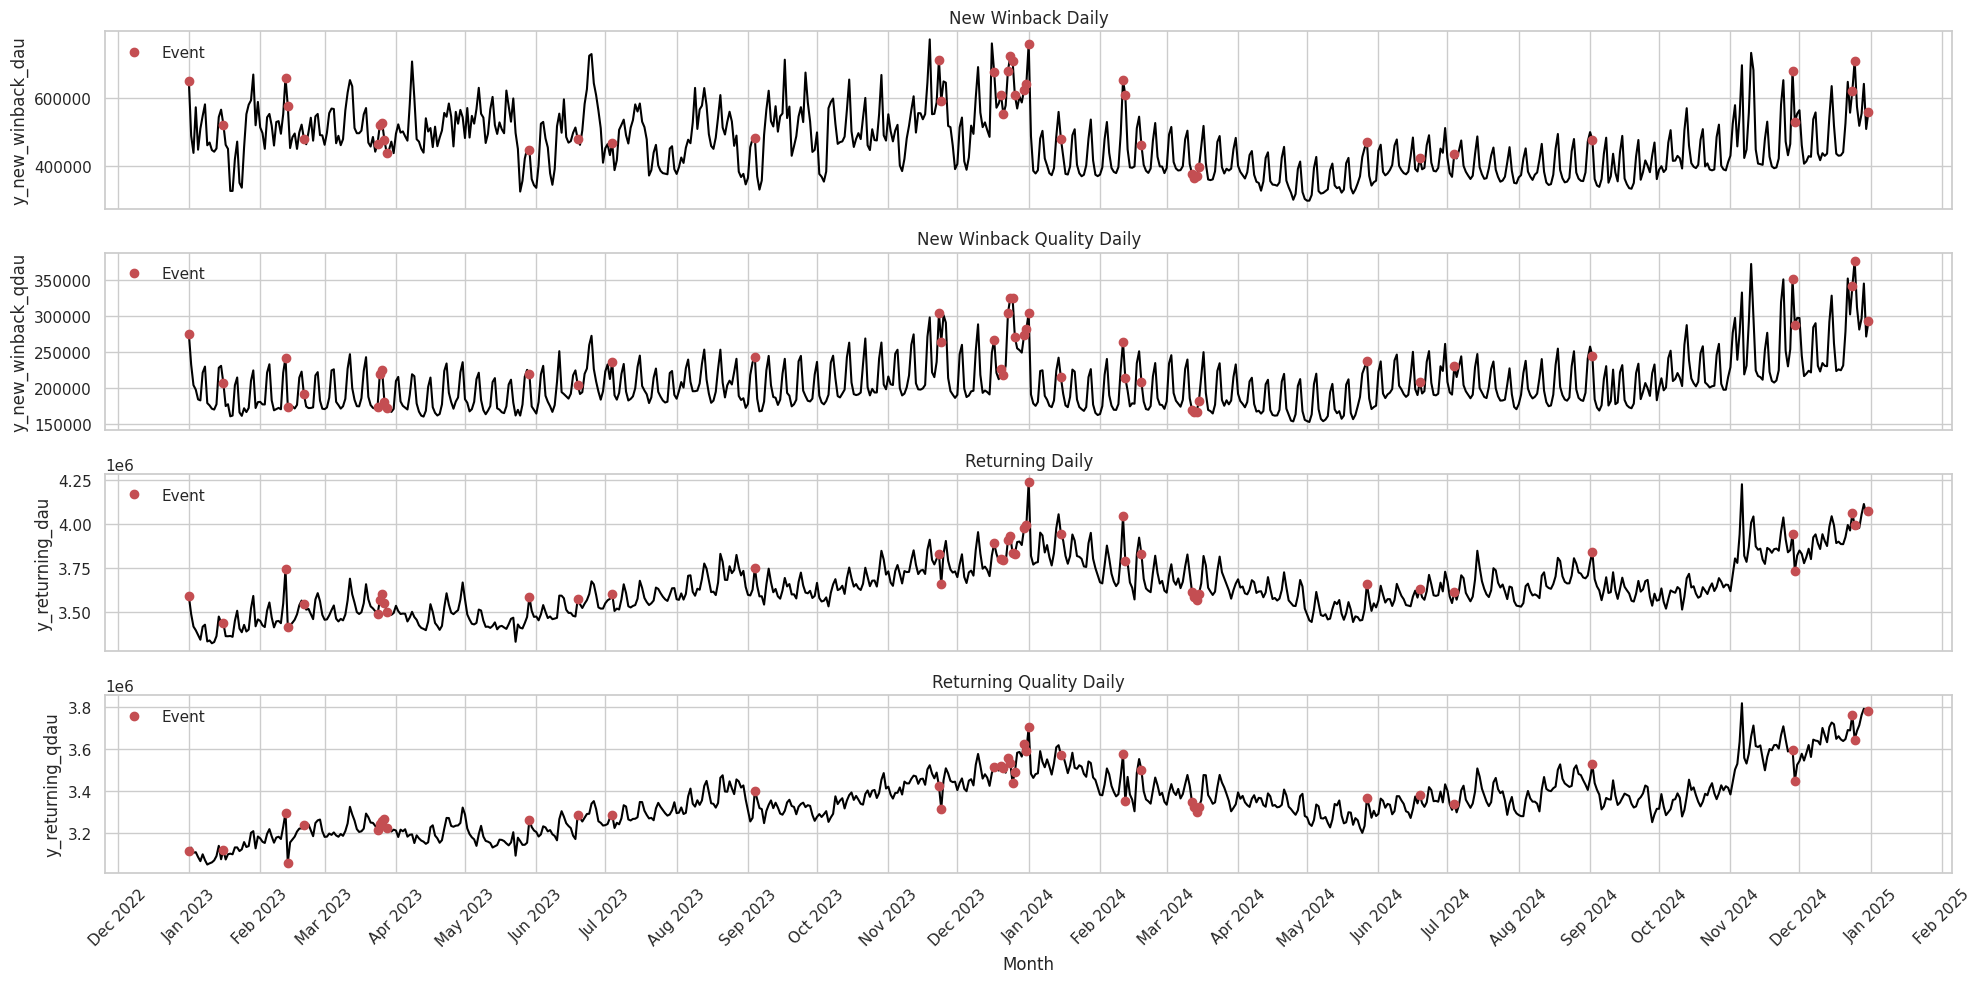

In [0]:


# Set plot style
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 10), sharex=True)

# Define variables to plot
metrics = [("y_new_winback_dau", "New Winback Daily"), ("y_new_winback_qdau", "New Winback Quality Daily"), ("y_returning_dau", "Returning Daily"), ("y_returning_qdau", "Returning Quality Daily")]

for ax, (col, title) in zip(axes, metrics):
    sns.lineplot(data=daily_df, x="day_dt", y=col, color="black", ax=ax)
    event_days = daily_df[pd.notna(daily_df["event"])]
    ax.plot(event_days["day_dt"], event_days[col], "ro", markersize=6, label="Event")
    ax.set(title=title, xlabel="Month", ylabel=col)
    ax.legend()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Add trend control vars

In [0]:
# Add annual trend

# Extract year
daily_df["year"] = daily_df["day_dt"].dt.year

# Use groupby cumcount for per-year linear trend
daily_df["annual_trend_2023"] = daily_df.groupby("year").cumcount().where(daily_df["year"] == 2023, 0)
daily_df["annual_trend_2024"] = daily_df.groupby("year").cumcount().where(daily_df["year"] == 2024, 0)

# segmented monthly trend
daily_df["month"] = daily_df["day_dt"].dt.to_period("M")

# Normalize day of month to [0, 1] scale per month
daily_df["day_frac"] = (
    daily_df.groupby("month")["day_of_month"]
    .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
)

# One-hot encode month
month_dummies = pd.get_dummies(daily_df["month"].astype(str), prefix="month", drop_first=False)

# Multiply each dummy by normalized day_frac
for col in month_dummies.columns:
    daily_df[f"trend_{col}"] = month_dummies[col] * daily_df["day_frac"]

## Specify Variables in the Model

In [0]:


# 1. control variables
# We just keep the holidays columns
control_columns = [col for col in daily_df.columns if col.startswith("event_") or col.startswith("dow_") or col.startswith(f"trend_{trend_type}")]
print("Control columns:", control_columns)

# 2. media variables
# Impressions only for now
media_activity = "imps" # must be "imps" or "spend"
channel_columns_raw = sorted(
    [
        col
        for col in daily_df.columns
        if ("channel_" in col) & (f"_{media_activity}" in col)
    ]
)

imps_channel_mapping = {
    "channel_app_imps": "MACS App",
    "channel_hmi_audio_imps": "HMI Audio",
    "channel_hmi_display_imps": "HMI Display",
    "channel_hmi_linear_imps": "HMI Linear",
    "channel_hmi_ooh_imps": "HMI OOH",
    "channel_hmi_video_imps": "HMI Digital Video",
    "channel_influencer_imps": "Influencer",
    "channel_macs_programmatic_imps": "MACS Programmatic",
    "channel_macs_social_imps": "MACS Social",
    "channel_oo_display_imps": "OO Display",
    "channel_oo_linear_imps": "OO Linear",
    "channel_oo_video_imps": "OO Video",
    "channel_paid_search_imps": "Paid Search",
    "channel_partnerships_imps": "Partnerships",
    "channel_podcast_one_imps": "Podcast One Audio",
}



spend_channel_mapping = {
    "channel_app_spend": "MACS App",
    "channel_hmi_audio_spend": "HMI Audio",
    "channel_hmi_display_spend": "HMI Display",
    "channel_hmi_linear_spend": "HMI Linear",
    "channel_hmi_ooh_spend": "HMI OOH",
    "channel_hmi_video_spend": "HMI Digital Video",
    "channel_influencer_spend": "Influencer",
    "channel_macs_programmatic_spend": "MACS Programmatic",
    "channel_macs_social_spend": "MACS Social",
    "channel_oo_display_spend": "OO Display",
    "channel_oo_linear_spend": "OO Linear",
    "channel_oo_video_spend": "OO Video",
    "channel_paid_search_spend": "Paid Search",
    "channel_partnerships_spend": "Partnerships",
    "channel_podcast_one_spend": "Podcast One Audio",
}

if media_activity == "imps":
    channel_mapping = imps_channel_mapping
    channel_columns = sorted(list(imps_channel_mapping.keys()))
    
else:
    channel_mapping = spend_channel_mapping
    channel_columns = sorted(list(spend_channel_mapping.keys()))
    
channel_names = sorted(list(imps_channel_mapping.values()))
sorted_spend_channel_names =  {k: spend_channel_mapping[k] for k in sorted(spend_channel_mapping, key=spend_channel_mapping.get)}

print("Channel columns:", channel_names)
print("Spend columns:", list(sorted_spend_channel_names.keys()))



# 3. y variable
y_var = f"y_{audience}_{quality_type}".lower()
print("y_var:", y_var)

data_df = daily_df[["day_dt", y_var, *channel_columns, *control_columns, *sorted_spend_channel_names]]
data_df = data_df.rename(columns=channel_mapping)

# reorder the channel columns in data_df only
sorted_channel_columns = sorted(channel_mapping.values())
data_df = data_df[['day_dt', y_var, *sorted_channel_columns, *control_columns, *sorted_spend_channel_names]]

# 4. Date column
data_df["day_dt"] = pd.to_datetime(data_df["day_dt"])
date_column = "day_dt"
data_df.columns

# remove event_0 column
if "event_0" in data_df.columns:
    data_df = data_df.drop(columns=["event_0"])

Control columns: ['event_anomaly_12_17_23', 'event_anomaly_12_20_2023', 'event_anomaly_12_21_2023', 'event_anomaly_3_12_2024', 'event_anomaly_3_13_2024', 'event_anomaly_3_14_2024', 'event_anomaly_3_15_2024', 'event_anomaly_3_24_23', 'event_anomaly_3_25_23', 'event_anomaly_3_26_23', 'event_anomaly_3_27_23', 'event_anomaly_3_28_23', 'event_blk_fri_2023', 'event_blk_fri_2024', 'event_day_after_superbowl_2023', 'event_day_after_superbowl_2024', 'event_day_b4_nye_2023', 'event_day_b4_xmas_eve_2023', 'event_ind_2023', 'event_ind_2024', 'event_juneteenth_2023', 'event_juneteenth_2024', 'event_lab_2023', 'event_lab_2024', 'event_mem_2023', 'event_mem_2024', 'event_mlk_2023', 'event_mlk_2024', 'event_ny23_2023', 'event_ny24_2024', 'event_nye_2023', 'event_nye_2024', 'event_pres_2023', 'event_pres_2024', 'event_superbowl_2023', 'event_superbowl_2024', 'event_thanks_2023', 'event_thanks_2024', 'event_xmas_2023', 'event_xmas_2024', 'event_xmas_day_after_2023', 'event_xmas_eve_2023', 'event_xmas_ev

## Specify Time-Slice-Cross-Validation Strategy

The main idea of the time-slice cross validation process is to fit the model on a time slice of the data and then evaluate it on the next time slice. We repeat this process for each time slice of the data. As we want to simulate a production-like environment where we enlarge our training data over time, we make the time-slice size grow over time.

Following the strategy of the example notebook, we use the media share of each channel to set the prior standard deviation of the beta parameters. We need to compute this share for EACH training time slice independently.

```{admonition} Data Leakage
:class: warning

It is very important to avoid data leakage when performing time-slice cross validation. This means that the model should not see any training data from the future. This also includes any data pre-processing steps!

For example, as mentioned above, we need to compute the media share for each training time slice independently if we want to avoid data leakage. Other sources of data leakage include using a global feature for thr trend component. In our case, we simply use an increasing variable `t` so we are safe as we just increase it by one for each time slice.
```

We wrap the main steps of the training procedure in a set of functions.

/root/.ipykernel/6336/command-7428869140403889-3322432380:44: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


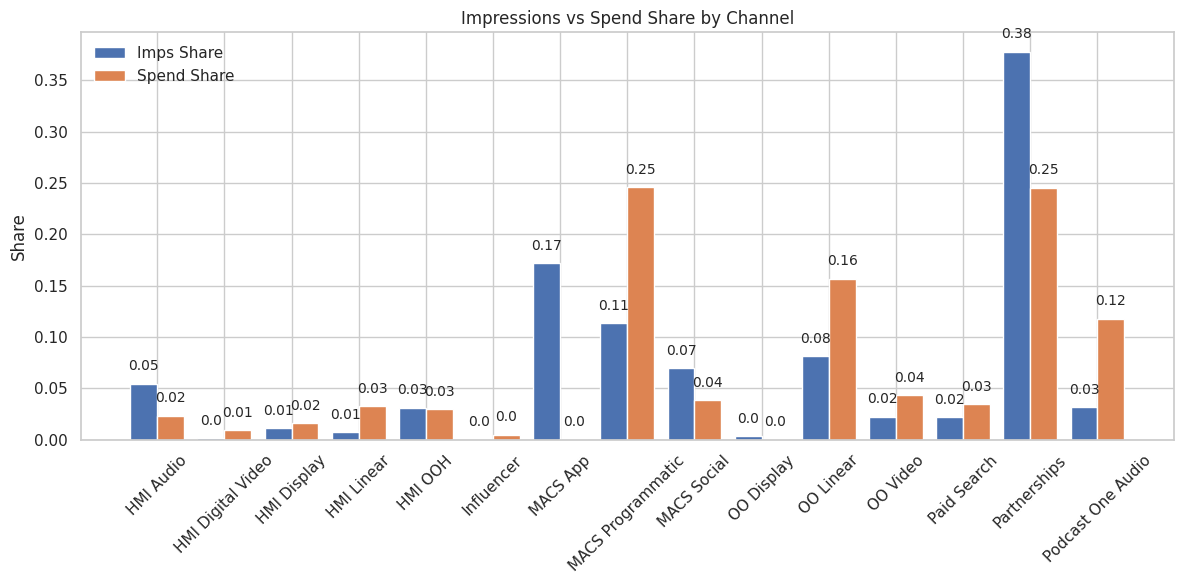

In [0]:
import numpy as np
import matplotlib.pyplot as plt

# Get shared channel names, ensuring consistent ordering
channels = sorted(channel_names)

# Get imps_shares and spend_shares
imps_shares = (
    data_df.melt(value_vars=channels, var_name="channel", value_name="imps")
    .groupby("channel", as_index=False)
    .agg({"imps": "sum"})
    .sort_values(by="channel")
    .assign(imps_share=lambda x: x["imps"] / x["imps"].sum())["imps_share"]
    .to_numpy()
)

spend_shares = (
    daily_df.melt(value_vars=list(spend_channel_mapping.keys()), var_name="channel", value_name="spend")
    .groupby("channel", as_index=False)
    .agg({"spend": "sum"})
    .sort_values(by="channel")
    .assign(spend_share=lambda x: x["spend"] / x["spend"].sum())["spend_share"]
    .to_numpy()
)

# Bar plot settings
x = np.arange(len(channels))  # label locations
width = 0.4  # bar width

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(x - width / 2, imps_shares, width, label="Imps Share")
plt.bar(x + width / 2, spend_shares, width, label="Spend Share")

# Add labels
for i in range(len(channels)):
    plt.text(x[i] - width / 2, imps_shares[i] + 0.01, str(round(imps_shares[i], 2)), ha="center", va="bottom", size=10)
    plt.text(x[i] + width / 2, spend_shares[i] + 0.01, str(round(spend_shares[i], 2)), ha="center", va="bottom", size=10)

plt.xticks(x, channels, rotation=45)
plt.ylabel("Share")
plt.title("Impressions vs Spend Share by Channel")
plt.legend()
plt.tight_layout()
plt.show()


##Adstock Alpha Tuning

In [0]:
def suggest_adstock_alpha_prior(
    contrib_share,
    imps_share,
    min_alpha=1,
    max_alpha=5,
    efficiency_means_short_memory=True,
):
    """
    Suggests a Beta prior for adstock_alpha based on contribution/impression efficiency.

    Parameters
    ----------
    contrib_share : float
        Fractional contribution share of the channel (0 to 1).
    imps_share : float
        Fractional impression share of the channel (0 to 1).
    min_alpha : float
        Lower bound for Beta(alpha, beta).
    max_alpha : float
        Upper bound for Beta(alpha, beta).
    efficiency_means_short_memory : bool
        If True, high efficiency implies short memory (low alpha).
        If False, high efficiency implies long memory (high alpha).

    Returns
    -------
    Prior
        A Beta distribution for adstock_alpha.
    float
        The efficiency ratio used in scaling.
    """
    if imps_share == 0:
        return Prior("Beta", alpha=1, beta=1), np.inf  # Uninformative

    # Define effectiveness ratio
    efficiency = contrib_share / imps_share
    scaled = np.clip(efficiency, 0, 5)

    # Smooth transformation: scale α depending on the desired interpretation
    scaled_value = (np.tanh(scaled) + 1) / 2  # range: [0, 1]

    if efficiency_means_short_memory:
        # High efficiency → short memory → lower alpha
        scaled_alpha = max_alpha - (max_alpha - min_alpha) * scaled_value
    else:
        # High efficiency → long memory → higher alpha
        scaled_alpha = min_alpha + (max_alpha - min_alpha) * scaled_value

    beta_param = max(1, max_alpha + min_alpha - scaled_alpha)

    return {"prior": Prior("Beta", alpha=round(scaled_alpha, 2), beta=round(beta_param, 2)),
            "alpha": scaled_alpha,
            "beta": beta_param,
            "ratio": efficiency}


In [0]:
returning_channel_contributions_12_1_23 = {
                    "HMI Audio": 0.0075,
                    "HMI Digital Video": 0.0231,
                    "HMI Display": 0.0549,
                    "HMI Linear": 0.0223,
                    "HMI OOH": 0.0622,
                    "Influencer": 0.0003,
                    "MACS App": 0.0511,
                    "MACS Programmatic": 0.0342,
                    "MACS Social": 0.0636,
                    "OO Display": 0.0043,
                    "OO Linear": 0.0904,
                    "OO Video": 0.0960,
                    "Paid Search": 0.1401,
                    "Partnerships": 0.2875,
                    "Podcast One Audio": 0.0803,
                }
if adstock_alpha_prior == "spend_imps_ratio":
    channel_data = {
        channel: {"contrib": contrib, "imps": imps}
        for channel, contrib, imps in zip(channels, spend_shares, imps_shares)
    }
    adstock_alpha_prior_dict = {
    channel: suggest_adstock_alpha_prior(v["contrib"], v["imps"])["prior"]
    for channel, v in channel_data.items()
    }
    efficiency_prior_dict = {
    channel: suggest_adstock_alpha_prior(v["contrib"], v["imps"])["ratio"]
    for channel, v in channel_data.items()
    }

    alpha_prior_list = [
        suggest_adstock_alpha_prior(v["contrib"], v["imps"])["alpha"]
        for channel, v in channel_data.items()
    ]

    beta_prior_list = [
        suggest_adstock_alpha_prior(v["contrib"], v["imps"])["beta"]
        for channel, v in channel_data.items()
    ]
    pprint.pprint(adstock_alpha_prior_dict)
    pprint.pprint(efficiency_prior_dict)
    pprint.pprint(alpha_prior_list)
    pprint.pprint(beta_prior_list)

elif adstock_alpha_prior == "contrib_imps_ratio":
    channel_data = {
        channel: {"contrib": contrib, "imps": imps}
        for channel, contrib, imps in zip(channels, list(returning_channel_contributions_12_1_23.values()), imps_shares)
    }
    adstock_alpha_prior_dict = {
    channel: suggest_adstock_alpha_prior(v["contrib"], v["imps"])["prior"]
    for channel, v in channel_data.items()
    }
    efficiency_prior_dict = {
    channel: suggest_adstock_alpha_prior(v["contrib"], v["imps"])["ratio"]
    for channel, v in channel_data.items()
    }

    alpha_prior_list = [
        suggest_adstock_alpha_prior(v["contrib"], v["imps"])["alpha"]
        for channel, v in channel_data.items()
    ]

    beta_prior_list = [
        suggest_adstock_alpha_prior(v["contrib"], v["imps"])["beta"]
        for channel, v in channel_data.items()
    ]
    pprint.pprint(adstock_alpha_prior_dict)
    pprint.pprint(efficiency_prior_dict)
    pprint.pprint(alpha_prior_list)
    pprint.pprint(beta_prior_list)

elif adstock_alpha_prior == "uniform":

    adstock_alpha_prior_dict = {
    channel: Prior("Beta", alpha=1, beta=1, dims="channel")
    for channel in channels
    }

    pprint.pprint(adstock_alpha_prior_dict)


{'HMI Audio': Prior("Beta", alpha=1, beta=1, dims="channel"),
 'HMI Digital Video': Prior("Beta", alpha=1, beta=1, dims="channel"),
 'HMI Display': Prior("Beta", alpha=1, beta=1, dims="channel"),
 'HMI Linear': Prior("Beta", alpha=1, beta=1, dims="channel"),
 'HMI OOH': Prior("Beta", alpha=1, beta=1, dims="channel"),
 'Influencer': Prior("Beta", alpha=1, beta=1, dims="channel"),
 'MACS App': Prior("Beta", alpha=1, beta=1, dims="channel"),
 'MACS Programmatic': Prior("Beta", alpha=1, beta=1, dims="channel"),
 'MACS Social': Prior("Beta", alpha=1, beta=1, dims="channel"),
 'OO Display': Prior("Beta", alpha=1, beta=1, dims="channel"),
 'OO Linear': Prior("Beta", alpha=1, beta=1, dims="channel"),
 'OO Video': Prior("Beta", alpha=1, beta=1, dims="channel"),
 'Paid Search': Prior("Beta", alpha=1, beta=1, dims="channel"),
 'Partnerships': Prior("Beta", alpha=1, beta=1, dims="channel"),
 'Podcast One Audio': Prior("Beta", alpha=1, beta=1, dims="channel")}


/root/.ipykernel/6336/command-6926091764016581-2766569624:44: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, 1, 0.96])


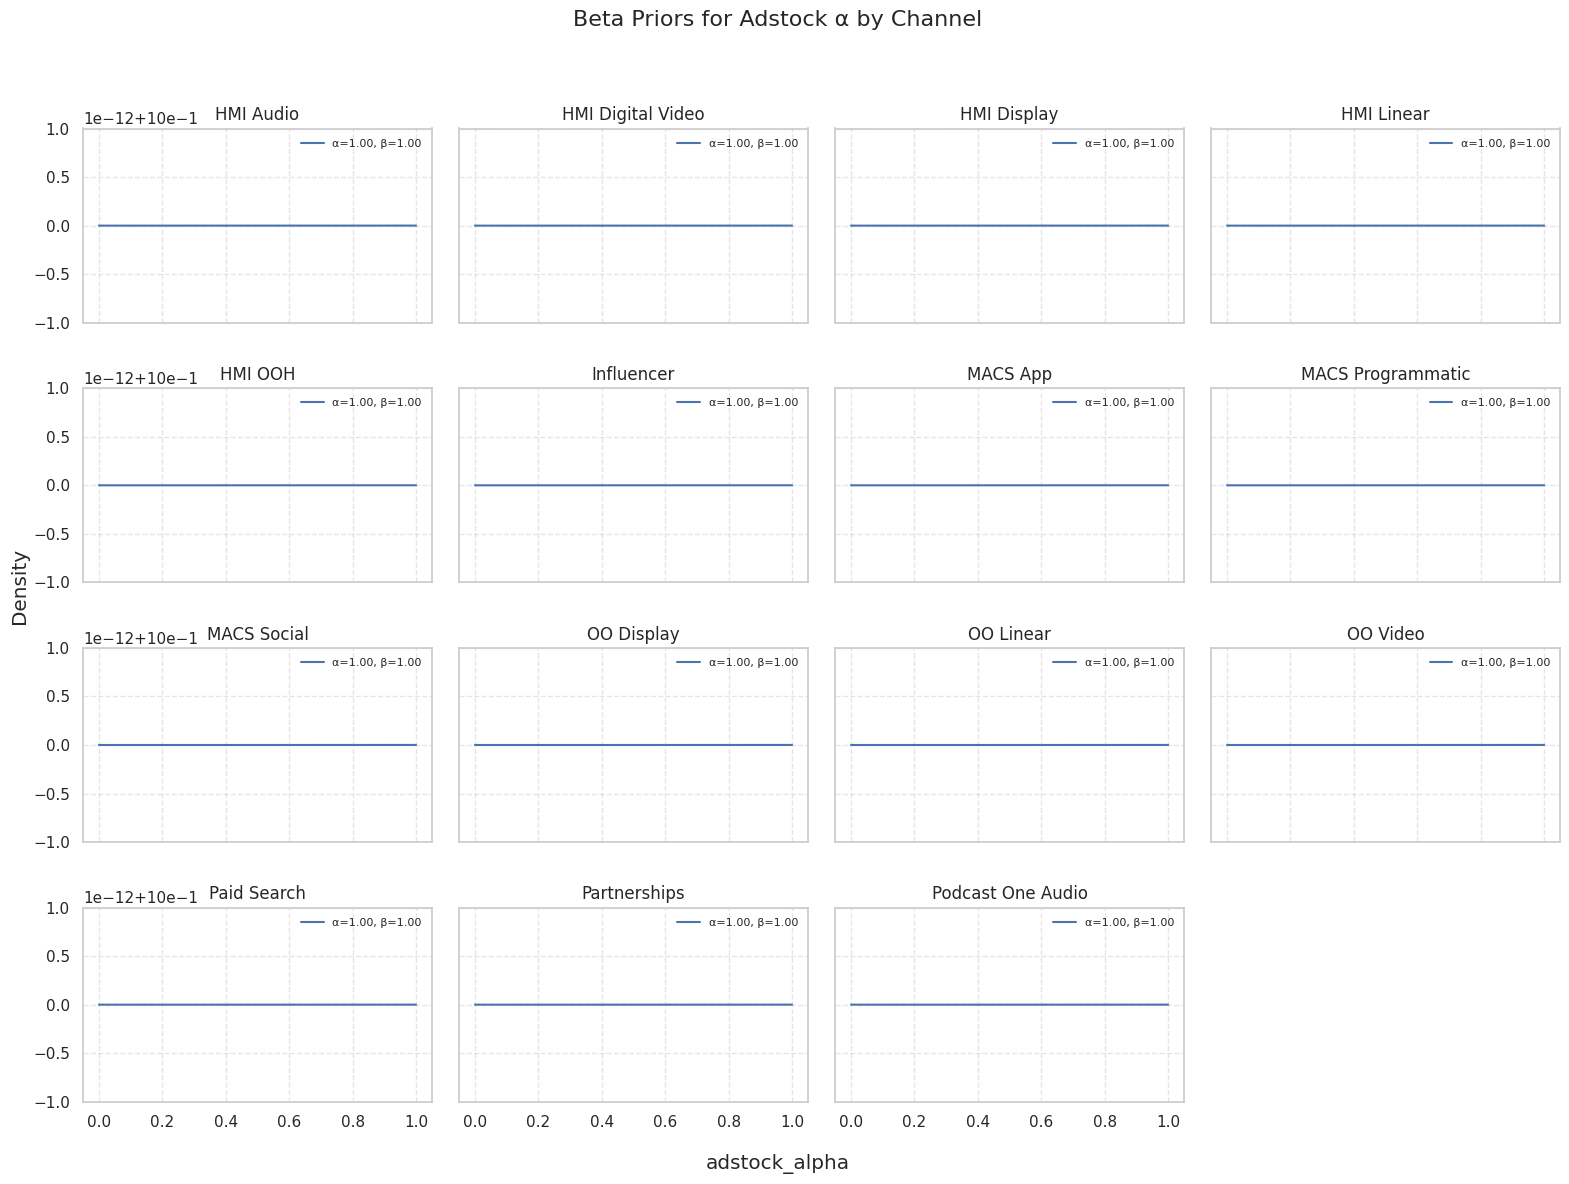

In [0]:
import math
from scipy.stats import beta

def plot_adstock_alpha_priors_facet(prior_dict, channels_to_plot=None, n_cols=4):
    """
    Plots Beta distributions for adstock_alpha priors per channel using facet grid layout.

    Parameters
    ----------
    prior_dict : dict
        Dictionary of {channel: Prior("Beta", alpha=..., beta=...)}
    channels_to_plot : list of str, optional
        Subset of channels to visualize. If None, plots all.
    n_cols : int
        Number of columns in the facet grid.
    """
    x = np.linspace(0, 1, 500)
    selected_channels = channels_to_plot or list(prior_dict.keys())
    n_channels = len(selected_channels)
    n_rows = math.ceil(n_channels / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, channel in enumerate(selected_channels):
        prior = prior_dict[channel]
        a = prior.parameters.get("alpha")
        b = prior.parameters.get("beta")

        y = beta.pdf(x, a, b)
        ax = axes[i]
        ax.plot(x, y, label=f"α={a:.2f}, β={b:.2f}")
        ax.set_title(channel)
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.legend(fontsize=8)

    # Hide unused subplots if any
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    fig.suptitle("Beta Priors for Adstock α by Channel", fontsize=16)
    fig.supxlabel("adstock_alpha")
    fig.supylabel("Density")
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


plot_adstock_alpha_priors_facet(adstock_alpha_prior_dict)



## Prior Specs

For each fold, we 
- compute prior sigma for saturation beta based on media activity shares or the last known media contribution of training set (i.e. 12/1/2023 below).
- filter out zero columns
- reset the model configurations

In [0]:
def compute_sigma_from_media_activity(
    X: pd.DataFrame, 
    media_activity: str = "imps"
) -> list[float]:
    """Compute the prior standard deviation of the beta parameters from the activity share of each channel."""

    if media_activity == "imps":
        media_cols = list(channel_names)
    elif media_activity == "spend":
        media_cols = list(sorted_spend_channel_names)

    n_channels = len(media_cols)
    total_activity_per_channel = data_df[media_cols].sum(axis=0)
    activity_share = total_activity_per_channel / total_activity_per_channel.sum()
    prior_sigma = n_channels * activity_share.to_numpy()
    return prior_sigma.tolist()



def get_mmm(X: pd.DataFrame, channel_names: list[str], control_columns: list[str], date_column: str) -> MMM:
    """Specify the model."""
    # specify the prior sigma for saturation beta
    if saturation_beta_prior_sigma == "prior_imps_share_sigma":
            prior_sigma = compute_sigma_from_media_activity(data_df, media_activity="imps")
    elif saturation_beta_prior_sigma == "prior_spend_share_sigma":
            prior_sigma = compute_sigma_from_media_activity(data_df, media_activity="spend")
    elif saturation_beta_prior_sigma == "prior_contribution_share_sigma":
            if audience == 'returning':
                returning_channel_contributions_12_1_23 = {
                    "HMI Audio": 0.0075,
                    "HMI Digital Video": 0.0231,
                    "HMI Display": 0.0549,
                    "HMI Linear": 0.0223,
                    "HMI OOH": 0.0622,
                    "Influencer": 0.0003,
                    "MACS App": 0.0511,
                    "MACS Programmatic": 0.0342,
                    "MACS Social": 0.0636,
                    "OO Display": 0.0043,
                    "OO Linear": 0.0904,
                    "OO Video": 0.0960,
                    "Paid Search": 0.1401,
                    "Partnerships": 0.2875,
                    "Podcast One Audio": 0.0803,
                }
                prior_sigma = [v * len(returning_channel_contributions_12_1_23) for v in returning_channel_contributions_12_1_23.values()]
            elif audience == 'new_winback':
                new_winback_channel_contributions_12_1_23 = {
                    "HMI Audio": 0.0122,
                    "HMI Digital Video": 0.0237,
                    "HMI Display": 0.0595,
                    "HMI Linear": 0.0327,
                    "HMI OOH": 0.0717,
                    "Influencer": 0.0002,
                    "MACS App": 0.0497,
                    "MACS Programmatic": 0.0281,
                    "MACS Social": 0.0541,
                    "OO Display": 0.0067,
                    "OO Linear": 0.0828,
                    "OO Video": 0.1046,
                    "Paid Search": 0.1387,
                    "Partnerships": 0.2712,
                    "Podcast One Audio": 0.0439,
                }
                prior_sigma = [v * len(new_winback_channel_contributions_12_1_23) for v in new_winback_channel_contributions_12_1_23.values()]

    # specify the prior alpha,beta for adstock_alpha beta prior distribution
    if adstock_alpha_prior in ['spend_imps_ratio', 'contrib_imps_ratio']:
        prior_alpha = alpha_prior_list
        prior_beta = beta_prior_list
    elif adstock_alpha_prior == 'uniform':
        # uniform beta distribution
        prior_alpha = [1 for _ in channels]
        prior_beta = [1 for _ in channels]
            
    
    print(f"Running prior_sigma using {saturation_beta_prior_sigma}")
    print(f"Running prior_alpha and prior_beta of adstock using {adstock_alpha_prior}")

    # Filter out control columns that are all zero for this fold
    nonzero_control_columns = [col for col in control_columns if X[col].sum() > 0]

    ### Prior Specs ####
    model_config = model_config_param | {"saturation_beta": Prior("HalfNormal", sigma=prior_sigma, dims="channel"),
                                         "adstock_alpha": Prior("Beta", alpha=prior_alpha, beta=prior_beta, dims="channel")}
    
    ###################

    return MMM(
        adstock=GeometricAdstock(l_max=64),
        saturation=LogisticSaturation(),
        date_column=date_column,
        channel_columns=channel_names, # use channel names 
        control_columns=nonzero_control_columns,
        model_config=model_config,
        time_varying_media=True,
        time_varying_intercept=False,
    )


def fit_mmm(
    mmm: MMM, X: pd.DataFrame, y: pd.Series, random_seed: np.random.Generator
) -> MMM:
    """Fit the model."""
    fit_kwargs = {
        "tune": tuneups,
        "chains": 4,
        "draws": draws,
        "nuts_sampler": "numpyro",
        "random_seed": random_seed,
        "prior_predictive": True,
        "log_likelihood": True
    }
    _ = mmm.fit(X, y, progressbar=True, **fit_kwargs)
    _ = mmm.sample_posterior_predictive(
        X, extend_idata=True, combined=True, progressbar=True, random_seed=random_seed
    )
    return mmm

For the sake of convenience, we define a data container to store the results of the time-slice cross validation step.

In [0]:
@dataclass
class TimeSliceCrossValidationResult:
    """Container for the results of the time slice cross validation."""

    X_train: pd.DataFrame
    y_train: pd.Series
    X_test: pd.DataFrame
    y_test: pd.Series
    mmm: MMM
    y_pred_test: pd.Series

Finally, we define the main function that performs the time-slice cross validation step by calling the functions defined above.

In [0]:
def time_slice_cross_validation_step(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    random_seed: np.random.Generator,
) -> TimeSliceCrossValidationResult:
    """Time-slice cross validation step.

    We fit the model on the training data and generate predictions for the test data.

    Parameters
    ----------
    X_train: pd.DataFrame
        Training data.
    y_train: pd.Series
        Training target.
    X_test: pd.DataFrame
        Test data.
    y_test: pd.Series
        Test target.

    Returns
    -------
    TimeSliceCrossValidationResult
        Results of the time slice cross validation step.
    """
    mmm = get_mmm(X_train, channel_names=channel_names, control_columns=control_columns, date_column=date_column)
    
    # Alternative using f-string
    print(f"Configurations for mmm: {pprint.pformat(mmm.model_config)}")
    mmm = fit_mmm(mmm, X_train, y_train, random_seed)

    y_pred_test = mmm.sample_posterior_predictive(
        X_test,
        include_last_observations=True,
        original_scale=True,
        extend_idata=False,
        progressbar=False,
        random_seed=random_seed,
    )

    return TimeSliceCrossValidationResult(
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        mmm=mmm,
        y_pred_test=y_pred_test,
    )

Prior distribution Checks:

In [0]:
def prior_dist_check_cv(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    random_seed: np.random.Generator):

    """
    Plot the prior distribution check
    """

    mmm = get_mmm(X_train, channel_names=channel_names, control_columns=control_columns, date_column=date_column)
    prior_predictive = mmm.sample_prior_predictive(X_train, y_train, samples=4_000, extend_idata=True)

    fig, ax = plt.subplots(figsize=(12, 3.5))  # shortened height

    fig = mmm.plot_prior_predictive(original_scale=True, ax=ax)
    # set y-axis to be in the range of y_var
    ax.legend(loc="upper right", bbox_to_anchor=(0.5, -0.2), ncol=4)
    ax.set_title("Prior Predictive Sampling - Training Data")
    ax.set(xlabel="date", ylabel=y_var)

    # Save and log to MLflow
    fig.savefig(f"Prior Predictive Check - Training Data.png", bbox_inches="tight")
    mlflow.log_artifact(f"Prior Predictive Check - Training Data.png")


We are now ready to run the time-slice cross validation loop 💪!

## Run Time-Slice-Cross-Validation Loop

Depending on the business requirements, we need to decide the initial number of observations to use for fitting the model (`n_init`) and the forecast horizon (`forecast_horizon`). For this example, we use the first year's observations to fit the model and then predict the next 12 observations (3 months).

In [0]:
# split the data into X and Y

x_columns = [date_column] + channel_names + control_columns
X = data_df.loc[:, x_columns]
y = data_df[y_var]

# Define your forecast horizons per month
n_init = 365
forecast_horizons = {
    "2024-01": 31,
    "2024-02": 29,
    "2024-03": 31,
}
months = sorted(list(forecast_horizons.keys()))
n_iterations = len(months)

mlflow.log_param("forecast_horizons", forecast_horizons)

{'2024-01': 31, '2024-02': 29, '2024-03': 31}

## Prior Distribution Checks

We can now generate prior predictive samples to see how the model behaves under the prior specification.


📦 Fold 0 — 2024-01
Train: 2023-01-01 00:00:00 to 2023-12-31 00:00:00
Test:  2024-01-01 00:00:00 to 2024-01-31 00:00:00
Running prior_sigma using prior_contribution_share_sigma
Running prior_alpha and prior_beta of adstock using uniform


Sampling: [adstock_alpha, gamma_control, intercept, media_temporal_latent_multiplier_raw_eta, media_temporal_latent_multiplier_raw_hsgp_coefs_offset, media_temporal_latent_multiplier_raw_ls, saturation_beta, saturation_lam, y, y_sigma]



📦 Fold 1 — 2024-02
Train: 2023-01-01 00:00:00 to 2024-01-31 00:00:00
Test:  2024-02-01 00:00:00 to 2024-02-29 00:00:00
Running prior_sigma using prior_contribution_share_sigma
Running prior_alpha and prior_beta of adstock using uniform


Sampling: [adstock_alpha, gamma_control, intercept, media_temporal_latent_multiplier_raw_eta, media_temporal_latent_multiplier_raw_hsgp_coefs_offset, media_temporal_latent_multiplier_raw_ls, saturation_beta, saturation_lam, y, y_sigma]



📦 Fold 2 — 2024-03
Train: 2023-01-01 00:00:00 to 2024-02-29 00:00:00
Test:  2024-03-01 00:00:00 to 2024-03-31 00:00:00
Running prior_sigma using prior_contribution_share_sigma
Running prior_alpha and prior_beta of adstock using uniform


Sampling: [adstock_alpha, gamma_control, intercept, media_temporal_latent_multiplier_raw_eta, media_temporal_latent_multiplier_raw_hsgp_coefs_offset, media_temporal_latent_multiplier_raw_ls, saturation_beta, saturation_lam, y, y_sigma]


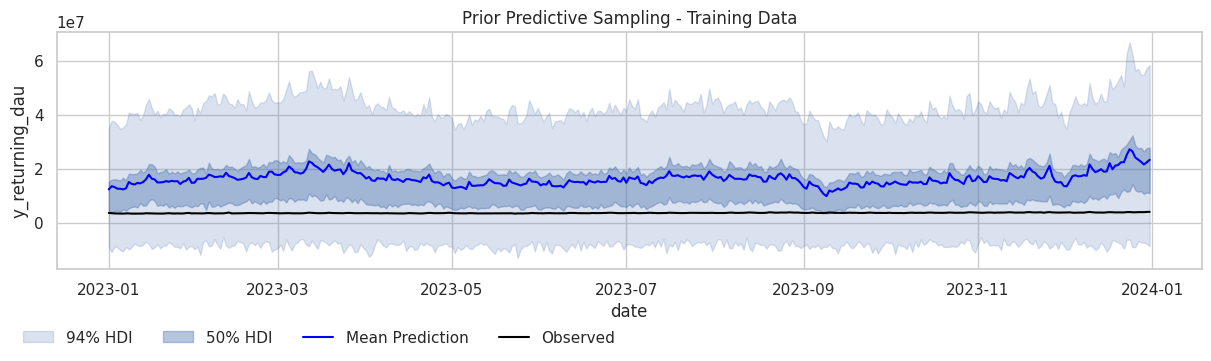

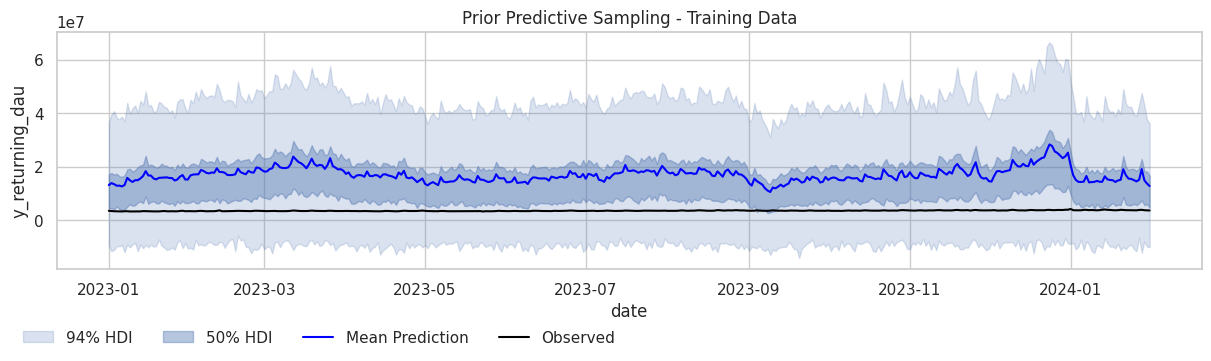

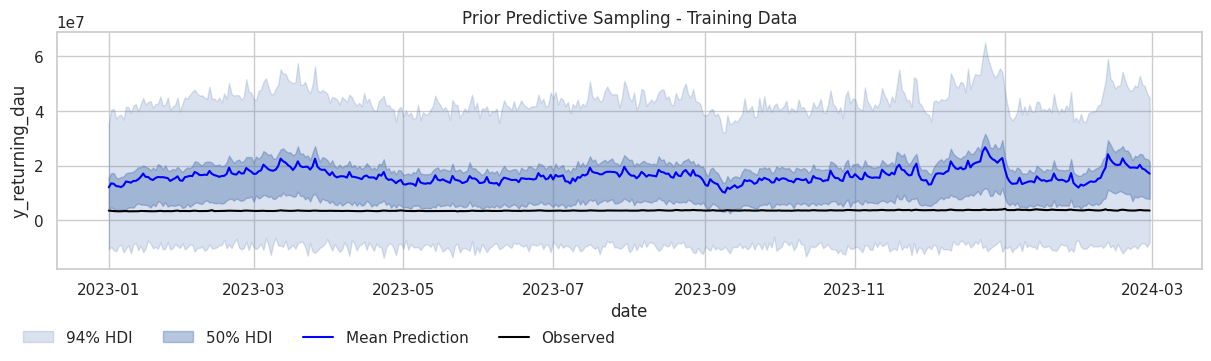

In [0]:
rng = np.random.default_rng(42)

prior_check_results = []
split_start = n_init

for i in range(n_iterations):
    month_str = months[i]
    forecast_horizon = forecast_horizons[month_str]
    step_size = forecast_horizon

    train_test_split = split_start

    if train_test_split + forecast_horizon > len(y):
        print(f"⚠️ Skipping iteration {i} ({month_str}) — not enough data")
        continue

    X_train = X.iloc[:train_test_split].copy()
    y_train = y.iloc[:train_test_split].copy()
    X_test = X.iloc[train_test_split : train_test_split + forecast_horizon].copy()
    y_test = y.iloc[train_test_split : train_test_split + forecast_horizon].copy()


    print(f"\n📦 Fold {i} — {month_str}")
    print(f"Train: {X_train[date_column].min()} to {X_train[date_column].max()}")
    print(f"Test:  {X_test[date_column].min()} to {X_test[date_column].max()}")

    result = prior_dist_check_cv(
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        random_seed=rng,
    )


    prior_check_results.append(result)
    split_start += step_size


Let's run it! 

In [0]:


# Initialize Ray
if not ray.is_initialized():
    ray.init(ignore_reinit_error=True)

# Ray remote function for CV step
@ray.remote
def run_time_slice_cv(X_train, y_train, X_test, y_test, rng, max_retries=2):
    import traceback
    for attempt in range(max_retries + 1):
        try:
            return time_slice_cross_validation_step(
                X_train=X_train,
                y_train=y_train,
                X_test=X_test,
                y_test=y_test,
                random_seed=rng,
            )
        except Exception as e:
            if attempt < max_retries:
                time.sleep(1)
            else:
                print(f"❌ FAILED: {e}")
                traceback.print_exc()
                return None

# Prepare tasks
futures = []
split_start = n_init
split_indices = []

for i in range(n_iterations):
    month_str = months[i]
    forecast_horizon = forecast_horizons[month_str]
    step_size = forecast_horizon

    train_test_split = split_start

    if train_test_split + forecast_horizon > len(y):
        print(f"⚠️ Skipping iteration {i} ({month_str}) — not enough data")
        continue

    X_train = X.iloc[:train_test_split].copy()
    y_train = y.iloc[:train_test_split].copy()
    X_test = X.iloc[train_test_split : train_test_split + forecast_horizon].copy()
    y_test = y.iloc[train_test_split : train_test_split + forecast_horizon].copy()

    print(f"Forecast horizon: {forecast_horizon} days")
    print(f"Iteration {i} ({month_str})")
    # print training period
    print(f"Training period: {X_train[date_column].min()} to {X_train[date_column].max()}")
    # print testing period
    print(f"Testing period: {X_test[date_column].min()} to {X_test[date_column].max()}")


    future = run_time_slice_cv.remote(
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        rng=rng,
    )
    futures.append(future)
    split_indices.append((i, month_str))

    split_start += step_size

# Collect results with tqdm
results = []
for i, future in tqdm(enumerate(futures), total=len(futures), desc="TimeSlice CV"):
    result = ray.get(future)
    if result is not None:
        results.append(result)
    else:
        print(f"⚠️ Skipped result at iteration {split_indices[i][0]}: {split_indices[i][1]}")

2025-05-14 17:14:22,543	INFO worker.py:1777 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Forecast horizon: 31 days
Iteration 0 (2024-01)
Training period: 2023-01-01 00:00:00 to 2023-12-31 00:00:00
Testing period: 2024-01-01 00:00:00 to 2024-01-31 00:00:00
Forecast horizon: 29 days
Iteration 1 (2024-02)
Training period: 2023-01-01 00:00:00 to 2024-01-31 00:00:00
Testing period: 2024-02-01 00:00:00 to 2024-02-29 00:00:00
Forecast horizon: 31 days
Iteration 2 (2024-03)
Training period: 2023-01-01 00:00:00 to 2024-02-29 00:00:00
Testing period: 2024-03-01 00:00:00 to 2024-03-31 00:00:00


TimeSlice CV:   0%|          | 0/3 [00:00<?, ?it/s]

(run_time_slice_cv pid=15554) Running prior_sigma using prior_contribution_share_sigma
(run_time_slice_cv pid=15554) Running prior_alpha and prior_beta of adstock using uniform
(run_time_slice_cv pid=15554) Configurations for mmm: {'adstock_alpha': Prior("Beta", alpha=[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], beta=[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], dims="channel"),
(run_time_slice_cv pid=15554)  'gamma_control': Prior("Normal", mu=0.0, sigma=0.03, dims="control"),
(run_time_slice_cv pid=15554)  'gamma_fourier': Prior("Laplace", mu=0, b=1, dims="fourier_mode"),
(run_time_slice_cv pid=15554)  'intercept': Prior("TruncatedNormal", mu=0.5, sigma=0.05, lower=0.4, upper=0.7),
(run_time_slice_cv pid=15554)  'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=2)),
(run_time_slice_cv pid=15554)  'media_tvp_config': HSGPKwargs(m=200, L=None, eta_lam=1.0, ls_mu=5.0, ls_sigma=10.0, cov_func=None),
(run_time_slice_cv pid=15554)  'saturation_beta': Prior("HalfNormal", sigma=[0.1125 0.3465 0.8235 0.33

Compiling.. :   0%|          | 0/500 [00:00<?, ?it/s]
(run_time_slice_cv pid=15530) 
  0%|          | 0/500 [00:00<?, ?it/s]
(run_time_slice_cv pid=15530) 
Compiling.. :   0%|          | 0/500 [00:00<?, ?it/s]
(run_time_slice_cv pid=15530) 
(run_time_slice_cv pid=15530) 
  0%|          | 0/500 [00:00<?, ?it/s]
(run_time_slice_cv pid=15530) 
(run_time_slice_cv pid=15530) 
Compiling.. :   0%|          | 0/500 [00:00<?, ?it/s]
(run_time_slice_cv pid=15540) 
(run_time_slice_cv pid=15540) 
(run_time_slice_cv pid=15540) 
(run_time_slice_cv pid=15540) 
(run_time_slice_cv pid=15540) 
(run_time_slice_cv pid=15540) 
(run_time_slice_cv pid=15540) 
(run_time_slice_cv pid=15554) 
(run_time_slice_cv pid=15554) 
(run_time_slice_cv pid=15554) 
(run_time_slice_cv pid=15554) 
(run_time_slice_cv pid=15554) 
(run_time_slice_cv pid=15554) 
Running chain 1:   0%|          | 0/500 [00:03<?, ?it/s]
(run_time_slice_cv pid=15540) 
Running chain 2:   0%|          | 0/500 [00:03<?, ?it/s]
(run_time_slice_cv pid=1

## Model Diagnostics

First, we evaluate whether we have any divergences in the model (we can extend the analysis more more model diagnostics).

In [0]:
sum([result.mmm.idata["sample_stats"]["diverging"].sum().item() for result in results])

Measure rhat

In [0]:
# TO DO: Log rhat to mlflow

for month, result in zip(months, results):
    idata = result.mmm.idata

    summary = az.summary(
        data=idata,
        var_names=[
            "intercept",
            "y_sigma",
            "saturation_beta",
            "saturation_lam",
            "adstock_alpha",
            "gamma_control",
        ],
        kind="diagnostics"
    )

    print(f"\n R-hat summary for {month}")
    print(summary["r_hat"].describe())

Lets visualize the posterior distributions of all model parameters from the first cross-validation fold of a PyMC-Marketing MMM model by plotting one histogram per parameter.

In [0]:
# First result only
month = months[0]
result = results[0]
idata = result.mmm.idata
    

# define param_names
param_names = list(idata.posterior.data_vars)
# define n_params
n_params = len(param_names)

fig, axes = plt.subplots(nrows=n_params, figsize=(15, 3 * n_params), sharex=False)

if n_params == 1:
        axes = [axes]

for i, param in enumerate(param_names):
        values = idata.posterior[param].values.flatten()
        axes[i].hist(values, bins=50, density=True)
        axes[i].set_title(param)
        axes[i].grid(True)

plt.tight_layout()
plt.show()

# Save and log
fig.savefig("parameter_posterior_distribution_fold0.png", bbox_inches="tight")
mlflow.log_artifact("parameter_posterior_distribution_fold0.png")

Model Trace:

In [0]:

# Plot trace and capture Axes array
_ = az.plot_trace(
    data=results[0].mmm.fit_result,
    var_names=[
        "intercept",
        "y_sigma",
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
        "gamma_control",
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)

# Get the current figure object after plot
fig = plt.gcf()
fig.suptitle("Model Trace - Fold 0", fontsize=16)

# Save and log
fig.savefig("model_trace_fold_0.png", bbox_inches="tight")
mlflow.log_artifact("model_trace_fold_0.png")

In [0]:

# Plot trace and capture Axes array
_ = az.plot_trace(
    data=results[-1].mmm.fit_result,
    var_names=[
        "intercept",
        "y_sigma",
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
        "gamma_control",
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)

# Get the current figure object after plot
fig = plt.gcf()
fig.suptitle("Model Trace - Last Fold", fontsize=16)

# Save and log
fig.savefig("model_trace_last_fold.png", bbox_inches="tight")
mlflow.log_artifact("model_trace_last_fold.png")

Prior vs. Posterior Influence

In [0]:
idata = results[0].mmm.idata
print(idata.groups())

In [0]:
'''
az.plot_dist_comparison(
    data=results[1].mmm.idata,
    var_names=[
        "intercept",
        "y_sigma",
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
        "gamma_control",
    ],
)
'''

## Evaluate Parameter Stability

Next, we look at the stability of the model parameters. For a good model, these should not change abruptly over time.

- Intercept

In [0]:


records_df = pd.DataFrame()

for month, result in zip(months, results):
    idata = result.mmm.idata
    intercept = idata.posterior["intercept"]  # Could be scalar or time-varying

    # Stack chain and draw into one dimension
    intercept_stacked = intercept.stack(sample=("chain", "draw"))

    # Check if intercept is time-varying (has more than 1 dim after stacking)
    non_sample_dims = [dim for dim in intercept_stacked.dims if dim != "sample"]

    if non_sample_dims:  # Time-varying intercept
        time_dim = non_sample_dims[0]
        n_days = intercept_stacked.sizes[time_dim]

        # Get the date range based on X_train
        start_date = pd.to_datetime(result.X_train[date_column].min())
        time_index = pd.date_range(start=start_date, periods=n_days, freq="D")

        # Reshape to DataFrame: [time x sample]
        intercept_df = pd.DataFrame(
            intercept_stacked.transpose(time_dim, "sample").values,
            index=time_index,
            columns=intercept_stacked.coords["sample"].values,
        )
        intercept_df = intercept_df.rename_axis("day_dt").reset_index()
        intercept_df["iteration"] = month

        # Melt to long format
        intercept_long = intercept_df.melt(
            id_vars=["day_dt", "iteration"], 
            var_name="sample_id", 
            value_name="intercept"
        )

        # Monthly summaries
        intercept_long["month_of_day_dt"] = intercept_long["day_dt"].dt.to_period("M")
        grouped = intercept_long.groupby("month_of_day_dt")["intercept"]

        monthly_summary = grouped.agg(mean="mean", median="median", std="std").reset_index()
        monthly_summary["lower_ci"] = grouped.quantile(0.025).values
        monthly_summary["upper_ci"] = grouped.quantile(0.975).values
        monthly_summary["iteration"] = month

        records_df = pd.concat([records_df, monthly_summary], ignore_index=True)

    else:  # Scalar intercept
        intercept_flat = intercept_stacked.values

        summary = {
            "iteration": month,
            "month_of_day_dt": pd.Period(result.X_train[date_column].min(), freq="M"),
            "mean": intercept_flat.mean(),
            "median": np.median(intercept_flat),
            "std": intercept_flat.std(),
            "lower_ci": np.quantile(intercept_flat, 0.025),
            "upper_ci": np.quantile(intercept_flat, 0.975),
        }

        records_df = pd.concat([records_df, pd.DataFrame([summary])], ignore_index=True)

# Convert month to string for plotting
records_df["month_of_day_dt"] = records_df["iteration"].astype(str)

display(records_df)

# plot the intercepts
fig, ax = plt.subplots(figsize=(10, 3))

az.plot_forest(
    data=[result.mmm.idata["posterior"] for result in results],
    model_names=[f"{i}" for i in months],
    var_names=["intercept"],
    combined=True,
    ax=ax,
)
fig.suptitle("Intercept", fontsize=18, fontweight="bold", y=1.06)
fig.legend(loc="upper right")


# Save and log to MLflow
fig.savefig("Intercept Stability.png", bbox_inches="tight")
mlflow.log_artifact("Intercept Stability.png")

- Gamma Control

In [0]:
fig, ax = plt.subplots(figsize=(12, 18))

az.plot_forest(
    data=[result.mmm.idata["posterior"] for result in results],
    model_names=[f"{i}" for i in months],
    var_names=["gamma_control"],
    combined=True,
    ax=ax,
)
fig.suptitle("Non-Media Coefficients (Gamma Control)", fontsize=18, fontweight="bold", y=1.06);

# Save and log to MLflow
fig.savefig("Non-Media Coefficients Stability.png", bbox_inches="tight")
mlflow.log_artifact("Non-Media Coefficients Stability.png")


- Adstock Alpha

In [0]:
fig, ax = plt.subplots(figsize=(12, 9))

az.plot_forest(
    data=[result.mmm.idata["posterior"] for result in results],
    model_names=[f"{i}" for i in months],
    var_names=["adstock_alpha"],
    combined=True,
    ax=ax,
)
fig.suptitle("Adstock Alpha", fontsize=18, fontweight="bold", y=1.06);
# label x-axis as "Adstock Alpha"
ax.set_xlabel("Alpha (Low=faster decay, High = slower decay)", fontsize=14, fontweight="bold")

# Save and log to MLflow
fig.savefig("Geo Adstock Alpha Stability.png", bbox_inches="tight")
mlflow.log_artifact("Geo Adstock Alpha Stability.png")

# double check whether this is theta 
#A higher ( \alpha ) results in a slower decay of media effects, leading to higher cumulative adstock values.
#A lower ( \alpha ) results in a faster decay, leading to lower cumulative adstock values.

- Saturation Beta

In [0]:
fig, ax = plt.subplots(figsize=(12, 9))

az.plot_forest(
    data=[result.mmm.idata["posterior"] for result in results],
    model_names=[f"{i}" for i in months],
    var_names=["saturation_beta"],
    combined=True,
    ax=ax,
)
fig.suptitle("Saturation Beta", fontsize=18, fontweight="bold", y=1.06);

ax.set_xlabel("Beta (Low = fast saturation, High = slow saturation)", fontsize=14, fontweight="bold")


# Save and log to MLflow
fig.savefig("Saturation Beta Stability.png", bbox_inches="tight")
mlflow.log_artifact("Saturation Beta Stability.png")


#High ( \beta ): Media effectiveness drops off quickly after reaching the saturation point, indicating that additional spend or impressions beyond a certain level have little incremental effect.
# Low ( \beta ): Media effectiveness decreases more gradually, allowing for a smoother decline in returns as spend or impressions increase.

- Saturation Lambda

In [0]:
fig, ax = plt.subplots(figsize=(9, 6))

az.plot_forest(
    data=[result.mmm.idata["posterior"] for result in results],
    model_names=[f"{i}" for i in months],
    var_names=["saturation_lam"],
    combined=True,
    ax=ax,
)
fig.suptitle("Saturation Lambda", fontsize=18, fontweight="bold", y=1.06);
# label x-axis as "Saturation Lambda"
ax.set_xlabel("Lambda (Low = fast saturation, High = slow saturation)", fontsize=14, fontweight="bold")

# If ( \lambda ) is small, the media channel saturates quickly, meaning additional spend or impressions beyond a certain point will have little incremental effect.
# If ( \lambda ) is large, the media channel can sustain higher levels of spend or impressions before experiencing diminishing returns.

# Save and log to MLflow
fig.savefig("Saturation Lambda Stability.png", bbox_inches="tight")
mlflow.log_artifact("Saturation Lambda Stability.png")

The parameters seem to be stable over time. This implies that the estimates ROAS will not change abruptly over time.

Let's look at contribution of each channel to the total spend for each iteration

## Evaluate Out of Sample Predictions

Finally, we evaluate the out of sample predictions. To begin with, we can simply plot the posterior predictive distributions for each iteration for both the training and test data.

In [0]:
fig, axes = plt.subplots(
    nrows=n_iterations,
    ncols=1,
    figsize=(20, 12),
    sharex=True,
    sharey=False,
    layout="constrained",
)

axes = axes.ravel()

for i, result in enumerate(results):
    ax = axes[i]
    result.mmm.plot_posterior_predictive(original_scale=True, ax=ax)

    hdi_prob = 0.94
    test_hdi = az.hdi(result.y_pred_test["y"].to_numpy().T, hdi_prob=hdi_prob)

    ax.fill_between(
        result.X_test[date_column],
        test_hdi[:, 0],
        test_hdi[:, 1],
        color="C1",
        label=f"{hdi_prob:.0%} HDI (test)",
        alpha=0.5,
    )
    ax.plot(X[date_column], y, marker="o", color="black")
    ax.axvline(result.X_test[date_column].iloc[0], color="C2", linestyle="--")
    ax.legend(loc="upper right")

axes[-1].set(xlim=(X[date_column].iloc[n_init - 9], None))
fig.suptitle("Posterior Predictive Check", fontsize=18, fontweight="bold", y=1.02);

# Save and log to MLflow
fig.savefig("Posterior Predictive Check.png", bbox_inches="tight")
mlflow.log_artifact("Posterior Predictive Check.png")

Overall, the out of sample predictions look very good 🚀!

We can quantify the model performance using the Continuous Ranked Probability Score (CRPS).

> *“The CRPS — Continuous Ranked Probability Score — is a score function that compares a single ground truth value to a Cumulative Distribution Function. It can be used as a metric to evaluate a model’s performance when the target variable is continuous and the model predicts the target’s distribution; Examples include Bayesian Regression or Bayesian Time Series models.”*


For a nice explanation of the CRPS, check out this [blog post](https://towardsdatascience.com/crps-a-scoring-function-for-bayesian-machine-learning-models-dd55a7a337a8).

In PyMC Marketing, we provide the function {func}`crps <pymc_marketing.metrics.crps>` to compute this metric. We can use it to compute the CRPS score for each iteration.

In [0]:
crps_results_train: list[float] = [
    crps(
        y_true=result.y_train.to_numpy(),
        y_pred=az.extract(
            # Scale the predictions back to the original scale
            apply_sklearn_transformer_across_dim(
                data=result.mmm.idata.posterior_predictive["y"],
                func=result.mmm.get_target_transformer().inverse_transform,
                dim_name="date",
            )
        )["y"]
        .to_numpy()
        .T,
    )
    for result in results
]


crps_results_test: list[float] = [
    crps(
        y_true=result.y_test.to_numpy(),
        y_pred=result.y_pred_test["y"].to_numpy().T,
    )
    for result in results
]

fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 7), sharex=True, sharey=False, layout="constrained"
)

ax[0].plot(crps_results_train, marker="o", color="C0", label="train")
ax[0].set(ylabel="CRPS", title="Train CRPS")
ax[1].plot(crps_results_test, marker="o", color="C1", label="test")
ax[1].set(xlabel="Iteration", ylabel="CRPS", title="Test CRPS")
fig.suptitle("CRPS for each iteration", fontsize=18, fontweight="bold", y=1.05);

# Save and log to MLflow
fig.savefig("CRPS.png", bbox_inches="tight")
mlflow.log_artifact("CRPS.png")



# Component Contributions

In [0]:
import pandas as pd

all_contributions = []

for i, result in enumerate(results):
    contrib = result.mmm.compute_mean_contributions_over_time(original_scale=True).copy()

    # Use the index as day
    contrib["day_dt"] = pd.to_datetime(contrib.index)
    contrib["fold"] = i + 1

    all_contributions.append(contrib)

df_all_contributions = pd.concat(all_contributions, ignore_index=True)
# make day_dt the index
df_all_contributions = df_all_contributions.set_index("day_dt", drop=False)

# melt df
melt_contrib = df_all_contributions.melt(id_vars=["day_dt", "fold"], var_name="channel", value_name="mean_contribution")

# aggregate by day_dt, and channel
mean_contrib = melt_contrib.groupby(["day_dt", "channel"])["mean_contribution"].mean().reset_index()


In [0]:
display(mean_contrib)

In [0]:
def compute_grouped_contribution_share(
    df,
    channel_groups,
    format="long",
    date_col="day_dt",
    freq="D",
    percentage_share=True,
):
    """
    Computes grouped contribution values or percentage shares over time.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with columns ['date', 'channel', 'mean_contribution'].
    channel_groups : dict
        Dictionary of group_name -> list of channel names.
    format : str
        Output format: 'long' or 'wide'.
    date_col : str
        Column name for date.
    freq : str
        Resampling frequency: 'D' = daily, 'W' = weekly, 'M' = monthly, etc.
    percentage_share : bool
        If True, return percentage share; if False, return original values.

    Returns
    -------
    pd.DataFrame
        Long or wide format DataFrame with contributions or percent shares by group.
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    # Aggregate contributions per date and channel
    grouped = df.groupby([date_col, "channel"], as_index=False).agg({"mean_contribution": "mean"})

    # Pivot to wide format
    df_pivot = grouped.pivot(index=date_col, columns="channel", values="mean_contribution").fillna(0)

    # Resample by frequency
    df_resampled = df_pivot.resample(freq).mean()

    # Sum contributions within each group
    group_contributions = {}
    for group_name, channels in channel_groups.items():
        valid_channels = [c for c in channels if c in df_resampled.columns]
        group_contributions[group_name] = df_resampled[valid_channels].sum(axis=1)

    # Build DataFrame of group contributions
    df_grouped = pd.DataFrame(group_contributions)
    df_grouped[date_col] = df_resampled.index

    if percentage_share:
        df_grouped_share = df_grouped.set_index(date_col).div(df_grouped.set_index(date_col).sum(axis=1), axis=0) * 100
        df_grouped_share = df_grouped_share.reset_index()
        value_col = "percent_share"
        df_out = df_grouped_share
    else:
        df_out = df_grouped
        value_col = "contribution"

    if format == "long":
        df_long = df_out.melt(id_vars=[date_col], var_name="group", value_name=value_col)
        return df_long.reset_index(drop=True)

    elif format == "wide":
        return df_out.reset_index(drop=True)

    else:
        raise ValueError("Invalid format. Choose 'long' or 'wide'.")


In [0]:
channel_groupings = {
        "Intercept": ['intercept'],
        "Day of Week Seasonality": [col for col in control_columns if col.startswith("dow_")],
        "Trend": [col for col in control_columns if col.startswith('trend_')],
        "Events": [col for col in control_columns if col.startswith("event_")],
        "Media": channel_names
    }

df_percent_share = compute_grouped_contribution_share(mean_contrib, channel_groupings, format="wide", date_col = "day_dt", freq="M", percentage_share=True)


# Save your DataFrame to a temporary file
df_percent_share.to_csv("high_level_contribution_percent.csv", index=False)

# Log it as an artifact in the current MLflow run
mlflow.log_artifact("high_level_contribution_percent.csv")

display(df_percent_share)

In [0]:
channel_groupings = {
        "Intercept": ['intercept'],
        "Day of Week Seasonality": [col for col in control_columns if col.startswith("dow_")],
        "Trend": [col for col in control_columns if col.startswith('trend_')],
        "Events": [col for col in control_columns if col.startswith("event_")],
        "Media": channel_names
    }

high_level_contrib = compute_grouped_contribution_share(mean_contrib, channel_groupings, format="wide", date_col = "day_dt", freq="D", percentage_share=False)


# Save your DataFrame to a temporary file
high_level_contrib.to_csv("high_level_contributions.csv", index=False)

# Log it as an artifact in the current MLflow run
mlflow.log_artifact("high_level_contributions.csv")

display(high_level_contrib)

In [0]:
channel_groupings = {
    "Base": (
        ['intercept']
        + [col for col in control_columns if col.startswith("dow_")]
        + [col for col in control_columns if col.startswith(f"trend_")]
        + [col for col in control_columns if col.startswith("event_")]
    ),
    "Partnerships": ["Partnerships"],
    "Paid Search": ["Paid Search"],
    "OO Video": ["OO Video"],
    "OO Linear": ["OO Linear"],
    "Podcast One Audio": ["Podcast One Audio"],
    "MACS Social": ["MACS Social"],
    "HMI OOH": ["HMI OOH"],
    "HMI Display": ["HMI Display"],
    "MACS App": ["MACS App"],
    "MACS Programmatic": ["MACS Programmatic"],
    "HMI Digital Video": ["HMI Digital Video"],
    "HMI Linear": ["HMI Linear"],
    "HMI Audio": ["HMI Audio"],
    "OO Display": ["OO Display"],
    "Influencer": ["Influencer"],
}

media_percent_share = compute_grouped_contribution_share(mean_contrib, channel_groupings, format="wide", date_col = "day_dt", freq="M")

# Save your DataFrame to a temporary file
media_percent_share.to_csv("media_contributions.csv", index=False)

# Log it as an artifact in the current MLflow run
mlflow.log_artifact("media_contributions.csv")

display(media_percent_share)

In [0]:
def plot_area_contributions(df, date_col="day_dt", title="Component Contributions Over Time"):
    """
    Plots an area chart of component contributions over time.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with datetime column and float columns per component.
    date_col : str
        Name of the datetime column.
    title : str
        Title of the plot.
    """
    # Sort by date to ensure correct plotting order
    df = df.sort_values(date_col)

    # Set datetime column as index
    df_plot = df.set_index(date_col)

    # Plot area chart
    ax = df_plot.plot.area(figsize=(14, 6), alpha=0.8)

    ax.set_title(title, fontsize=14)
    ax.set_ylabel("Contribution")
    ax.set_xlabel("Date")
    ax.grid(True, which="major", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()


plot_area_contributions(media_percent_share, date_col="day_dt", title="Monthly Component Contribution Shares")

In [0]:
# for any negative coefficients, replace with 0
high_level_contrib_positive = high_level_contrib.copy()
high_level_contrib_positive['Trend'] = high_level_contrib['Trend'].clip(lower=0)
high_level_contrib_positive['Events'] = high_level_contrib['Events'].clip(lower=0)
high_level_contrib_positive['Day of Week Seasonality'] = high_level_contrib['Day of Week Seasonality'].clip(lower=0)

plot_area_contributions(high_level_contrib_positive, title="Monthly Component Contributions")

# Save and log to MLflow
fig.savefig("CRPS.png", bbox_inches="tight")
mlflow.log_artifact("CRPS.png")

In [0]:
base_share = media_percent_share["Base"].loc[media_percent_share["day_dt"].dt.year == 2024].mean()
media_share = 100 - base_share

print("Base Contribution Share:", base_share)
print("Media Contribution Share:", media_share)

mlflow.log_metrics({"base_share": round(base_share,2), "media_share": round(media_share,2)})



# Model Performance Metrics

In [0]:

def compute_out_sample_metrics_cv(results, metric="mape"):
    """
    Computes MAPE (Mean Absolute Percentage Error) across all folds of a
    cross-validated PyMC-Marketing MMM.

    Parameters
    ----------
    results : list of TimeSliceCrossValidationResult

    Returns
    -------
    float
        MAPE across all folds.
    """

    if metric == "mape":
      all_y_true = []
      all_y_pred = []

      for result in results:
            y_true = result.y_test.values.flatten()
            y_pred_samples = result.y_pred_test["y"].to_numpy()  # shape: (T, S)

            y_pred_mean = y_pred_samples.T.mean(axis=0)

            all_y_true.extend(y_true)
            all_y_pred.extend(y_pred_mean)

      # Convert to numpy arrays
      all_y_true = np.array(all_y_true)
      all_y_pred = np.array(all_y_pred)

      mape = np.mean(np.abs((all_y_true - all_y_pred) / all_y_true)) * 100
      return mape
    elif metric == "coverage":
      total = 0
      covered = 0

      for result in results:
          y_true = result.y_test.values.flatten()

          # shape: (T, S), need (S, T) for az.hdi
          y_pred_samples = result.y_pred_test["y"].to_numpy().T  # shape: (samples, time)
          hdi = az.hdi(y_pred_samples, hdi_prob=hdi_prob)  # shape: (T, 2)

          lower, upper = hdi[:, 0], hdi[:, 1]
          is_covered = (y_true >= lower) & (y_true <= upper)

          covered += is_covered.sum()
          total += len(y_true)

      coverage_rate = covered / total
      return coverage_rate

    
    else:
      raise ValueError("metric must be either mape, coverage, or pseudo_r2")

In [0]:
mape = compute_out_sample_metrics_cv(results, metric="mape")
coverage = compute_out_sample_metrics_cv(results, metric="coverage")

print("MAPE for out-of-sample:", mape)
print("coverage for out-of-sample:", coverage)

mlflow.log_metric("mape", round(mape,2))
mlflow.log_metric("coverage", round(coverage,2))

Posterior fit per fold:

In [0]:

for month, result in zip(months,results):

  fig = result.mmm.plot_posterior_predictive(original_scale=True, figsize=(10, 3))
  # Get Axes and set x-axis limits
  ax = fig.axes[0]  # assumes there's one main plot
  ax.set_xlim([pd.to_datetime('2023-12'), pd.to_datetime("2024-04")])
  ax.set_title(f"Posterior Predictions - {month}")
  print(month, result.X_test["day_dt"].min(), result.X_test["day_dt"].max())

  # Save and log to MLflow
  fig.savefig(f"Posterior Predictions Over Time - {month}", bbox_inches="tight")
  mlflow.log_artifact(f"Posterior Predictions Over Time - {month}.png")

  # TO DO: troubleshoot why the last month isn't showing

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_mape_over_time(results):
    """
    Plot MAPE over time across all test folds.

    Parameters
    ----------
    results : list of TimeSliceCrossValidationResult
    """
    all_fold_mape = []

    for result in results:
        y_true = result.y_test.values.flatten()
        y_pred = result.y_pred_test["y"].to_numpy().T.mean(axis=0)
        dates = result.X_test["day_dt"].values

        # Avoid div-by-zero
        mask = y_true != 0
        y_true = y_true[mask]
        y_pred = y_pred[mask]
        dates = dates[mask]

        mape = np.abs((y_true - y_pred) / y_true)

        fold_df = pd.DataFrame({
            "day_dt": pd.to_datetime(dates),
            "mape": mape
        })
        all_fold_mape.append(fold_df)

    # Combine all folds and average if needed
    mape_df = pd.concat(all_fold_mape)
    mape_daily = mape_df.groupby("day_dt").mean().reset_index()
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(mape_daily["day_dt"], mape_daily["mape"] * 100, marker="o")
    ax.set_ylabel("MAPE (%)")
    ax.set_xlabel("Date")
    ax.set_title("MAPE Over Time Across Folds")
    ax.grid(True)
    plt.tight_layout()

    # Save and log to MLflow
    fig.savefig("MAPE Over Time Across Folds - Out Sample", bbox_inches="tight")
    mlflow.log_artifact("MAPE Over Time Across Folds - Out Sample.png")

plot_mape_over_time(results)



Bayesian R^2